In [ ]:
import mmml
import matplotlib.pyplot as plt
import patchworklib as pw
import os
from pathlib import Path
import numpy as np
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import jax
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


<Figure size 100x100 with 0 Axes>

In [ ]:


current_path = Path.cwd()
print(current_path)
data_path = current_path / ".." / "data"
data_files = list(data_path.glob("*npz"))
for i in range(len(data_files)):
    print(i, data_files[i])

/home/ericb/mmml
0 /home/ericb/mmml/../data/240124_combined_water.npz
1 /home/ericb/mmml/../data/Data_new.npz
2 /home/ericb/mmml/../data/esp13415.npz
3 /home/ericb/mmml/../data/esp2000.npz
4 /home/ericb/mmml/../data/md17_ethanol.npz
5 /home/ericb/mmml/../data/mulitpoles1000.npz
6 /home/ericb/mmml/../data/mulitpoles10000.npz
7 /home/ericb/mmml/../data/mulitpoles766000.npz
8 /home/ericb/mmml/../data/qm9-combined.npz
9 /home/ericb/mmml/../data/qm9-esp-dip-1000-0.npz
10 /home/ericb/mmml/../data/qm9-esp-dip-1000-1.npz
11 /home/ericb/mmml/../data/qm9-esp-dip-1000-2.npz
12 /home/ericb/mmml/../data/qm9-esp-dip-1000-3.npz
13 /home/ericb/mmml/../data/qm9-esp-dip-40000-0.npz
14 /home/ericb/mmml/../data/qm9-esp-dip-40000-1.npz
15 /home/ericb/mmml/../data/qm9-esp-dip-40000-2.npz
16 /home/ericb/mmml/../data/qm9-esp-dip-6907-3.npz
17 /home/ericb/mmml/../data/qm9-esp10000.npz
18 /home/ericb/mmml/../data/qm9-esp1021.npz
19 /home/ericb/mmml/../data/qm9-esp20000.npz
20 /home/ericb/mmml/../data/qm9-esp400

In [ ]:
index = 3
data_path_resolved = data_files[index].resolve()
data_loaded = np.load(data_path_resolved, 
allow_pickle=True)
data_path_resolved

PosixPath('/mnt/d/data/esp13415.npz')

R
(13415, 60, 3)
Z
(13415, 60)
N
(13415,)


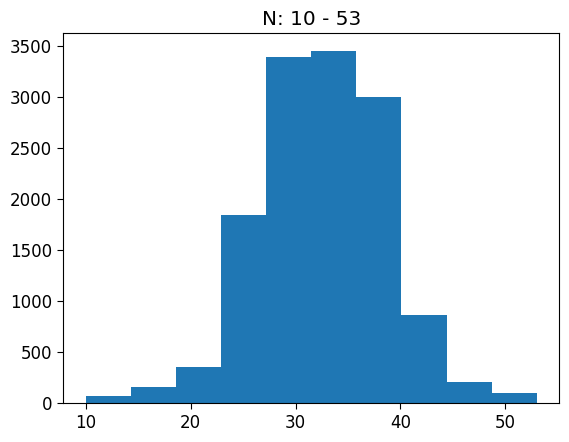

mono
(13415, 60, 1)
esp
(13415, 5346)
n_grid
(13415,)


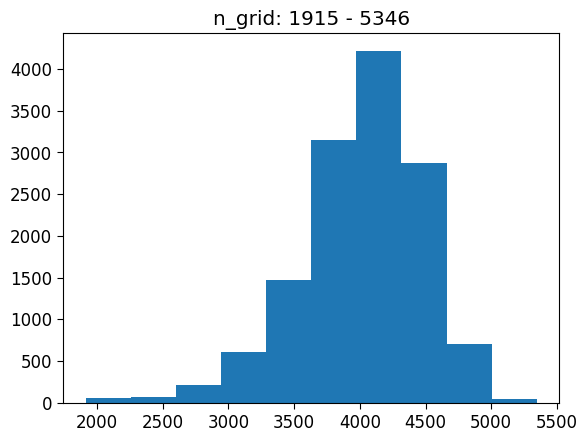

vdw_surface
(13415, 5346, 3)


In [ ]:
for k in data_loaded.keys():
    print(k)
    shape = data_loaded[k].shape
    print(shape
    )
    if len(shape) < 3:
        d = data_loaded[k]
        d = d.flatten()
        plt.hist(d)
        title = f"{k}: {d.min()} - {d.max()}"
        plt.title(title)
        plt.show()

In [6]:
from mmml import dcmnet

In [7]:
import jax

from mmml.dcmnet.dcmnet.data import prepare_datasets
from mmml.dcmnet.dcmnet.modules import MessagePassingModel
from mmml.dcmnet.dcmnet.training import train_model, train_model_dipo

key = jax.random.PRNGKey(0)


In [8]:
model = MessagePassingModel(
    features=16, max_degree=2, num_iterations=2,
    num_basis_functions=16, cutoff=4.0, n_dcm=2,
    include_pseudotensors=False,
)

In [9]:
prepare_datasets?

Signature:
prepare_datasets(
    key,
    num_train,
    num_valid,
    filename,
    clean=False,
    esp_mask=False,
    clip_esp=False,
    natoms=60,
)
Docstring:
Prepare datasets for training and validation.

Wrapper function that calls prepare_multiple_datasets and then
creates train/validation splits and dictionaries.

Parameters
----------
key : jax.random.PRNGKey
    Random key for dataset shuffling
num_train : int
    Number of training samples
num_valid : int
    Number of validation samples
filename : str or list
    Filename(s) to load datasets from
clean : bool, optional
    Whether to filter failed calculations, by default False
esp_mask : bool, optional
    Whether to create ESP masks, by default False
clip_esp : bool, optional
    Whether to clip ESP to first 1000 points, by default False
natoms : int, optional
    Maximum number of atoms per system, by default 60

Returns
-------
tuple
    A tuple containing train_data and valid_data dictionaries
File:      ~/mmml/mmm

In [10]:
train_data, valid_data = prepare_datasets(
    key, num_train=1200, num_valid=100,
    filename=[data_path_resolved],
    clean= False, esp_mask=True,
    # clip_esp=True,
)




shape (13415, 60, 3)
R (13415, 60, 3)
(13415, 60, 3)
['R', 'Z', 'N', 'mono', 'esp', 'vdw_surface', 'n_grid', 'espMask']
13415
0 R 13415 (13415, 60, 3)
1 Z 13415 (13415, 60)
2 N 13415 (13415, 1)
3 mono 13415 (13415, 60)
4 esp 13415 (13415, 5346)
5 vdw_surface 13415 (13415, 5346, 3)
6 n_grid 13415 (13415,)
7 espMask 13415 (13415, 5346)


In [11]:
esp_data = train_data["esp"]
esp_data.shape

(1200, 5346)

In [12]:
train_model?

Signature:     
train_model(
    key,
    model,
    train_data,
    valid_data,
    num_epochs,
    learning_rate,
    batch_size,
    writer,
    ndcm,
    esp_w=1.0,
    restart_params=None,
    *,
    loss_step_fn: Callable = <PjitFunction of <function train_step at 0x7a58c1726f80>>,
    eval_step_fn: Callable = <PjitFunction of <function eval_step at 0x7a58c1449480>>,
    optimizer_fn: Callable = <function <lambda> at 0x7a58c144a8c0>,
    use_ema: bool = True,
    ema_decay: float = 0.999,
    use_grad_clip: bool = False,
    grad_clip_norm: float = 2.0,
    log_extra_metrics: Optional[Callable] = <function _log_extra_metrics_none at 0x7a58c144a7a0>,
    save_best_params_with_ema: bool = True,
    extra_valid_args: dict = None,
    extra_train_args: dict = None,
)
Call signature: train_model(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function train_model_general at 0x7a58c144a710>, loss_step_fn=<PjitFunction of <...> tra_metrics=<function _log_extr

In [13]:
new_params = None

params, valid_loss = train_model(
    key=key, model=model,
    writer=None,
    train_data=train_data, valid_data=valid_data,
    num_epochs=100, learning_rate=1e-3, batch_size=1,
    ndcm=model.n_dcm, esp_w=10000.0,
)



Preparing batches
..................


KeyboardInterrupt: 

In [ ]:
params['params'].keys()



In [ ]:
from mmml.dcmnet.dcmnet.analysis import dcmnet_analysis, prepare_batch

?dcmnet_analysis
?prepare_batch

In [ ]:
index

In [ ]:
batch.keys()

In [ ]:
batch = prepare_batch(data_files[3], index=-1)
batch['com'] = np.mean(batch['R'].T, axis=-1) # center of mass
batch["Dxyz"] = batch["R"] - batch["com"]
output = dcmnet_analysis(params, model, batch)
print(output["rmse_model_masked"]), print(output["rmse_model"])
output.keys()

In [ ]:
import ase
from ase.visualize import view
atoms = ase.Atoms(batch["Z"][:int(batch["N"])], 
batch["R"][:int(batch["N"])])
view(atoms, viewer="x3d")


In [ ]:
import patchworklib as pw

xy_ax = pw.Brick()
xy_ax.scatter(batch["esp"], output['esp_pred'], s=1)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
xy_ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
xy_ax.set_aspect('equal')

ax_true = pw.Brick()
Npoints = 4150
vdw_surface_min = np.min(batch["vdw_surface"][0], axis=0)
vdw_surface_max = np.max(batch["vdw_surface"][0], axis=0)

ax_true.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=batch["esp"][0][:Npoints],
s=0.01
)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
# ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
ax_true.set_aspect('equal')

ax_pred = pw.Brick()

ax_pred.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=output['esp_pred'][:Npoints],
s=0.01
)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
# ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
ax_pred.set_aspect('equal')


ax_diff = pw.Brick()
ax_diff.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=batch["esp"][0][:Npoints] - output['esp_pred'][:Npoints],
s=0.01
)
ax_diff.set_aspect('equal')

for _ in [ax_pred, ax_true, ax_diff]:
    _.set_xlim(vdw_surface_min[0], -vdw_surface_min[0])
    _.set_ylim(vdw_surface_min[1], -vdw_surface_min[0])


xy_ax | ax_pred | ax_true | ax_diff



In [ ]:
charge_ax = pw.Brick()
charge_ax.matshow(output["mono"][0][:int(batch["N"])])

In [ ]:
R = output["dipo"][:int(batch["N"])*2]
Z = np.array([1 if _ > 0 else 1 for _ in output["mono"][0][:int(batch["N"])].flatten()])
R.shape, Z.shape
dcm_atoms = ase.Atoms(Z, R)
view(dcm_atoms,  viewer="x3d",
viewer_kwargs={"width": 1000, "height": 1000, "show_unit_cell": 1})

In [ ]:
new_params, valid_loss = train_model(
    key=key, model=model,
    writer=None,
    train_data=train_data, valid_data=valid_data,
    num_epochs=100, learning_rate=5e-3, batch_size=1,
    ndcm=model.n_dcm, esp_w=10000.0,
    restart_params=params if new_params is None else new_params,
)